In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sci
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report

In [3]:
df = pd.read_csv('../dataset/numerical_data.csv') #only use with full dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155361 entries, 0 to 155360
Data columns (total 37 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   nsites                                        155361 non-null  int64  
 1   nelements                                     155361 non-null  int64  
 2   volume                                        155361 non-null  float64
 3   density                                       155361 non-null  float64
 4   density_atomic                                155361 non-null  float64
 5   deprecated                                    155361 non-null  int64  
 6   energy_per_atom                               152149 non-null  float64
 7   formation_energy_per_atom                     152149 non-null  float64
 8   energy_above_hull                             152149 non-null  float64
 9   is_stable                                     15

In [5]:
df['xas'].describe()

count    155361.000000
mean          0.392119
std           0.488225
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: xas, dtype: float64

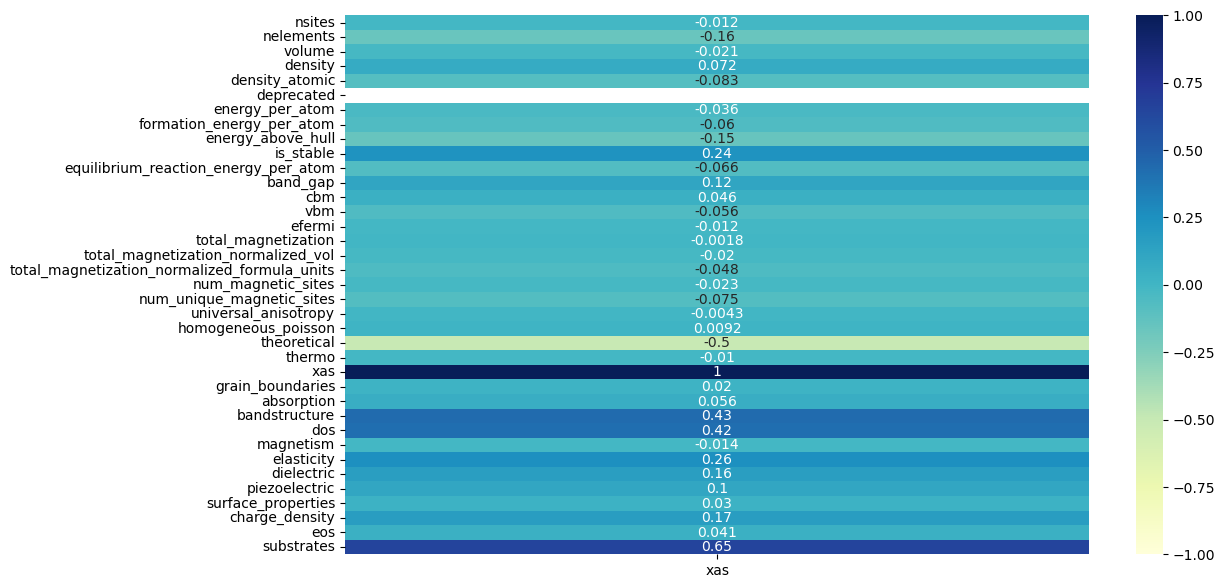

In [6]:
numerical_df = df.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(12, 7))
corr_matrix = numerical_df.corr()

corr_band_gap = corr_matrix[['xas']]
sns.heatmap(corr_band_gap, annot=True, cmap="YlGnBu", vmin=-1, vmax=1)

plt.show()

In [1]:
feature_names=['substrates','bandstructure','dos','elasticiity','band_gap','magnetism','energy_above_hull','nelements','density_atomic','vbm']